# EDA To Prediction (DieTanic)

참고 : https://www.kaggle.com/ash316/eda-to-prediction-dietanic

# 1. Exploratory Data Analysis (EDA)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
data.isnull().sum()  # null값 확인

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Age, Cabin, Embarked 에 null값이 있다. 수정해보겠다.

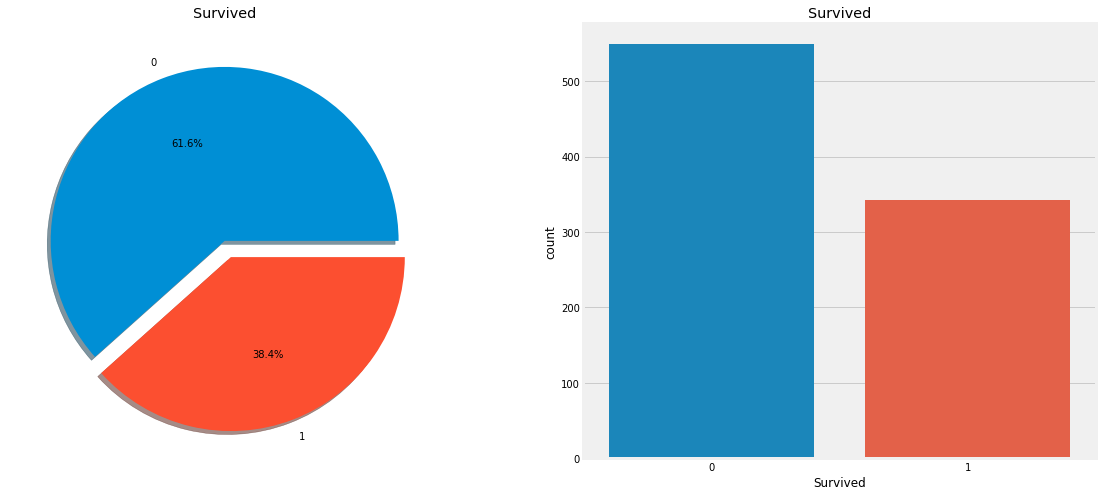

In [9]:
### Survived 확인

f, ax = plt.subplots(1,2,figsize=(18,8))
data['Survived'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Survived')
ax[0].set_ylabel('')

sns.countplot('Survived',data=data,ax=ax[1])
ax[1].set_title('Survived')
plt.show()

살아남은 승객은 많지 않다.

training set의 891명 중 약 350명, 즉 38.4%만이 살아남았다. 데이터를 더 자세히 조사해 어떤 승객이 살아남았는지 알아봐야한다. dataset의 다양한 feature(Age,Embarked,Sex 등)를 통해 생존률을 확인할 것이다. 

우선 feature의 유형을 이해해보자.

Types Of Features 

- Categorical Features : 범주형 변수 <br>
범주형 변수는 두 개 이상의 범주가 있는 변수이며 해당 feature를 범주로 분류할 수 있다. 범주형 변수는 정렬하거나 순서를 지정할 수 없다. Nominal 변수라고도 한다. <br>
: Sex, Embarked
<br><br>
- Ordinal Features : 순서형 변수 <br>
순서형 변수는 범주형 변수와 비슷하지만 값에 상대적인 순서가 있다는 차이가 있다. 순서형 변수는 상대적인 정렬이 가능하다. <br>
: Pclass
<br><br>
- Continuous Feature : 연속형 변수 <br>
두 값이나 최소값, 최대값 사이에서 값을 취할 수 있는 경우 연속형이라고 한다. <br>
: Age

## 1.1. Analysing The Features

### 1.1.1. Sex : Categorical Features

In [10]:
data.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

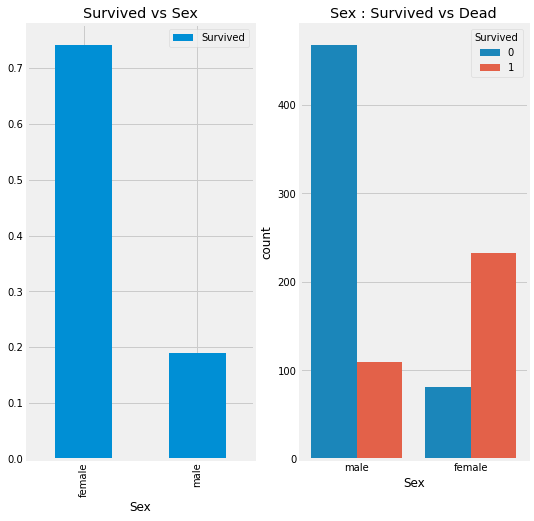

In [14]:
f, ax = plt.subplots(1,2,figsize=(8,8))
data[['Sex','Survived']].groupby(['Sex']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')

sns.countplot('Sex',hue='Survived',data=data,ax=ax[1])
ax[1].set_title('Sex : Survived vs Dead')
plt.show()

승객 중 남성이 훨씬 많지만, 생존한 여성의 수가 생존한 남성의 수의 약 2배다. 여성의 생존률은 약 75%이고 반면 남성의 생존률은 약 18~19%이다. 모델링에 중요한 feature로 보인다. 다른 feature도 확인해보자.

### 1.1.2. Pclass : Ordinal Feature

In [17]:
pd.crosstab(data.Pclass,data.Survived,margins=True).style.background_gradient(cmap='YlGnBu')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


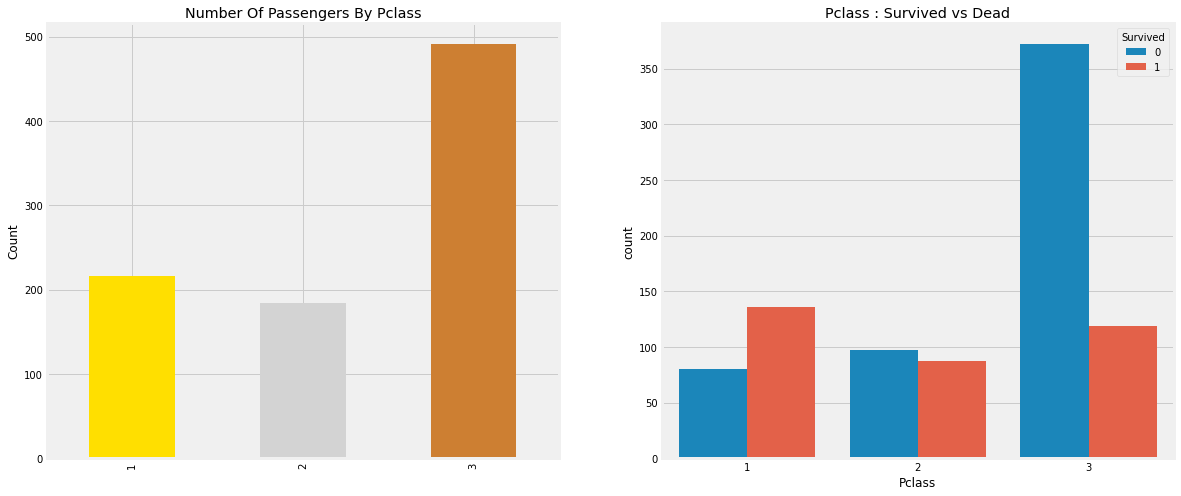

In [19]:
f, ax = plt.subplots(1,2,figsize=(18,8))
data['Pclass'].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'],ax=ax[0])
ax[0].set_title('Number Of Passengers By Pclass')
ax[0].set_ylabel('Count')

sns.countplot('Pclass',hue='Survived',data=data,ax=ax[1])
ax[1].set_title('Pclass : Survived vs Dead')
plt.show()

Pclass 1 승객들이 구조에서 높은 우선순위를 가졌다는 것을 볼 수 있다. Pclass 3의 승객이 훨씬 많지만 생존률은 약 25%이다. Pclass 1은 약 63%, Pclass 2는 약 48%다.

Sex와 Pclass를 생존률과 함께 살펴보자.

In [22]:
pd.crosstab([data.Sex, data.Survived], data.Pclass, margins=True).style.background_gradient(cmap='summer_r')

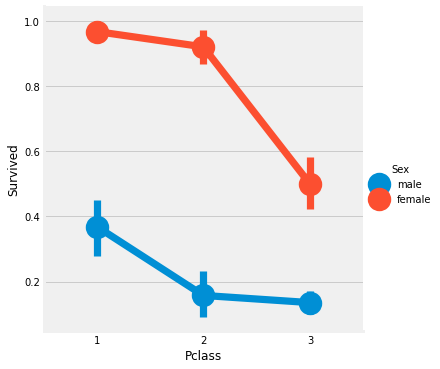

In [23]:
sns.factorplot('Pclass','Survived',hue='Sex',data=data)

범주형 변수를 쉽게 분리할 수 있는 FactorPlot을 사용한다. <br>
CrossTab과 FactorPlot을 보면, Pclass 1 여성의 생존률이 94명 중 3명을 제외한 95~96%이다. Pclass와 상관없이 여성은 구조시 1순위였음을 알 수 있다. Pclass 1의 남성 생존률도 매우 낮다.

### 1.1.3. Age : Continuous Feature

In [25]:
print('가장 나이 많은 승객:', data['Age'].max(), 'Years')
print('가장 나이 어린 승객 :', data['Age'].min(), 'Years')
print('승객의 평균 나이 :', data['Age'].mean(), 'Years')

가장 나이 많은 승객: 80.0 Years
가장 나이 어린 승객 : 0.42 Years
승객의 평균 나이 : 29.69911764705882 Years


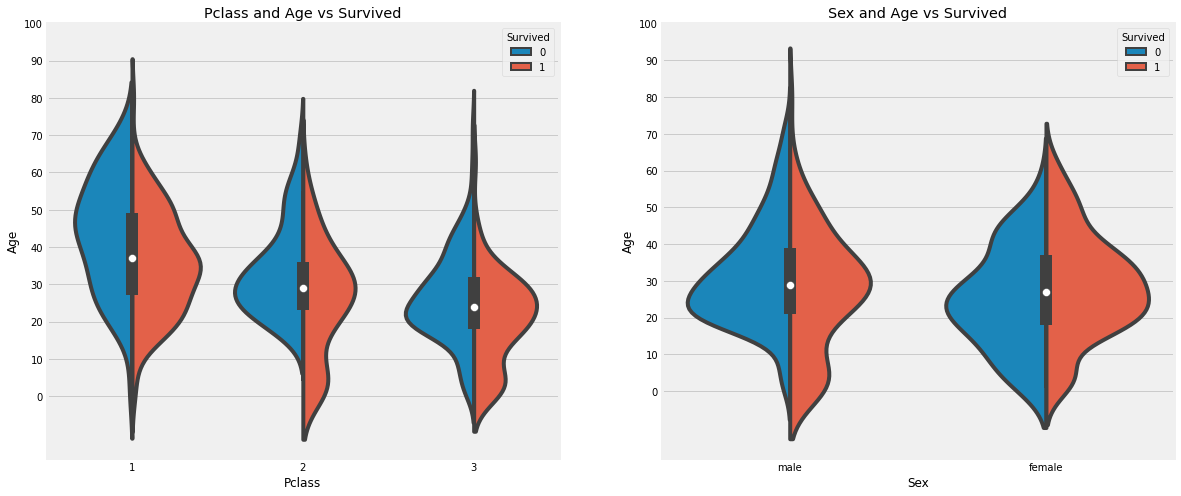

In [31]:
f, ax = plt.subplots(1,2,figsize=(18,8))
sns.violinplot('Pclass','Age',hue='Survived',data=data,split=True,ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0,110,10))

sns.violinplot('Sex','Age',hue='Survived',data=data,split=True,ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0,110,10))
plt.show()

- Pclass에 따라 어린이 수도 증가하는데 10세 미만 어린이의 생존률은 Pclass와 상관없이 양호하다.
- Pclass 1 20~50대 승객의 생존가능성이 높고 여성은 더 높다.
- 남성의 생존률은 나이가 많을수록 감소한다.

위에서 봤듯이, Age는 177개의 null값이 있다. NaN 값을 나이 평균으로 대체할 수 있지만, 4살 아이를 평균 나이 29세로 대체할 수는 없다. 따라서 Name 변수를 확인해보면, Mr나 Mrs와 같은 이니셜이 있는데 그 구분의 평균 나이값으로 대체할 수 있다.

Name 에 있는 이니셜을 새로운 feature로 만들어보자.

In [34]:
data['Initial'] = 0
for i in data:
    data['Initial'] = data.Name.str.extract('([A-Za-z]+)\.')

. 앞의 문자열을 Name에서 추출해 Initial 변수에 입력했다.

In [35]:
pd.crosstab(data.Initial, data.Sex).T.style.background_gradient(cmap='summer_r')  #Initial과 Sex를 함께 확인

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


Mlle, Mme와 같이 Miss를 잘못 적은 것들이 있어 올바른 값으로 대체한다.

In [52]:
data['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
                       ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)

In [53]:
data.groupby('Initial')['Age'].mean()  # Initial 변수 각 값의 평균 나이를 확인

Initial
Master     4.616750
Miss      21.887097
Mr        32.798677
Mrs       35.984252
Other     45.888889
Name: Age, dtype: float64

In [54]:
# NaN 값을 각 Initial의 평균 나이로 대체
data.loc[(data.Age.isnull())&(data.Initial=='Mr'),'Age'] = 33
data.loc[(data.Age.isnull())&(data.Initial=='Mrs'),'Age'] = 36
data.loc[(data.Age.isnull())&(data.Initial=='Master'),'Age'] = 5
data.loc[(data.Age.isnull())&(data.Initial=='Miss'),'Age'] = 22
data.loc[(data.Age.isnull())&(data.Initial=='Other'),'Age'] = 46

In [55]:
data.Age.isnull().any()  # False 반환 : 더이상 null값 없음

False

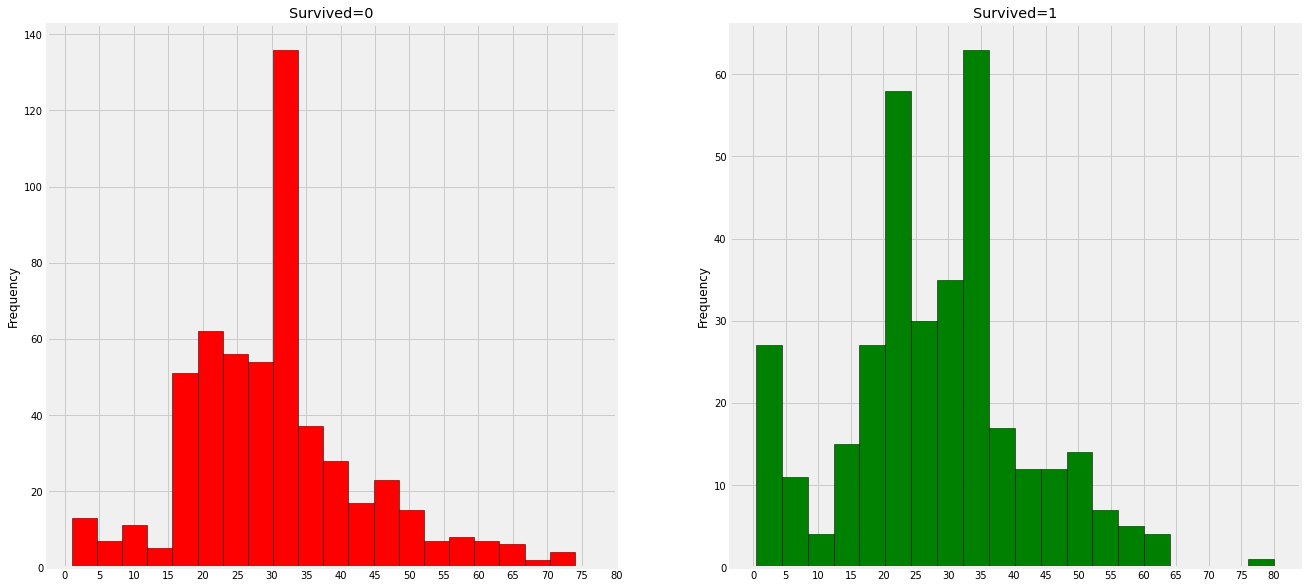

In [56]:
f, ax = plt.subplots(1,2,figsize=(20,10))
data[data['Survived']==0].Age.plot.hist(ax=ax[0],bins=20,edgecolor='black',color='red')
ax[0].set_title('Survived=0')
x1 = list(range(0,85,5))
ax[0].set_xticks(x1)

data[data['Survived']==1].Age.plot.hist(ax=ax[1],color='green',bins=20,edgecolor='black')
ax[1].set_title('Survived=1')
x2 = list(range(0,85,5))
ax[1].set_xticks(x2)

plt.show()

- 5세 미만 유아는 많은 수가 구조되었다.
- 가장 나이 많은 승객(80세)는 구조되었다.
- 최대 인원의 사망자는 30~40대 그룹에서 나왔다.

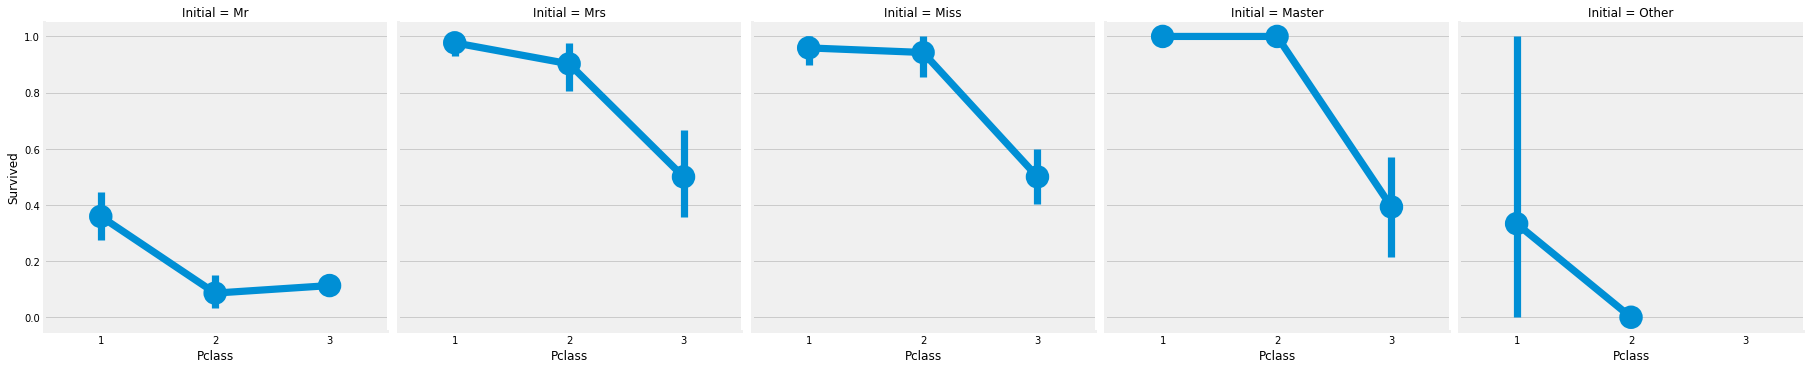

In [57]:
sns.factorplot('Pclass','Survived',col='Initial',data=data)
plt.show()

### 1.1.4. Embarked : Categorical Value

In [58]:
pd.crosstab([data.Embarked,data.Pclass],[data.Sex,data.Survived],margins=True).style.background_gradient(cmap='summer_r')

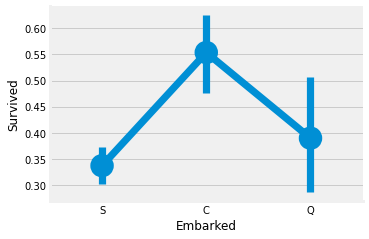

In [59]:
# Emabrked에 따른 생존률
sns.factorplot('Embarked','Survived',data=data)
fig = plt.gcf()
fig.set_size_inches(5,3)
plt.show()

항구 C의 생존률이 0.55로 가장 높고 S가 가장 낮다.

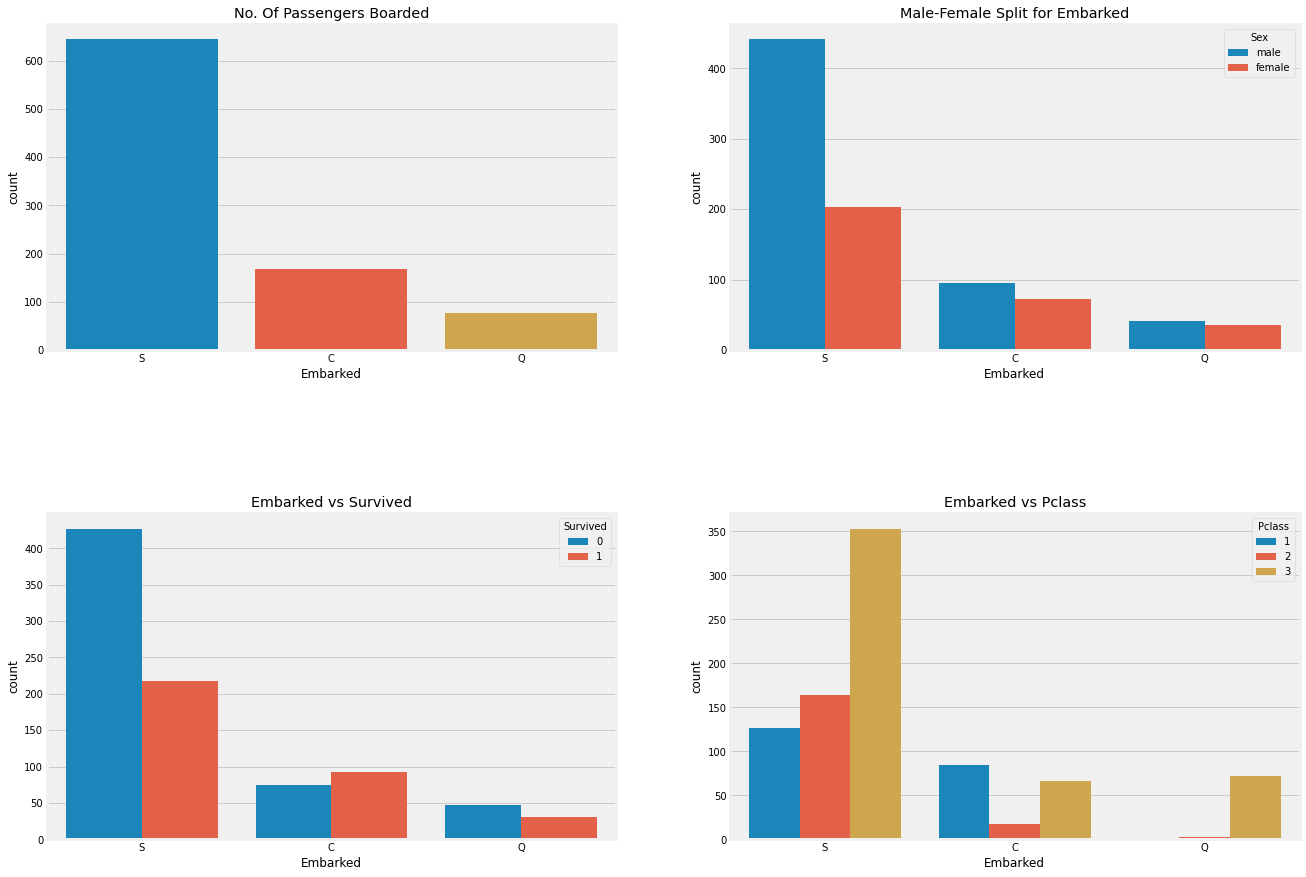

In [61]:
f, ax = plt.subplots(2,2,figsize=(20,15))
sns.countplot('Embarked',data=data,ax=ax[0,0])
ax[0,0].set_title('No. Of Passengers Boarded')

sns.countplot('Embarked',hue='Sex',data=data,ax=ax[0,1])
ax[0,1].set_title('Male-Female Split for Embarked')

sns.countplot('Embarked',hue='Survived',data=data,ax=ax[1,0])
ax[1,0].set_title('Embarked vs Survived')

sns.countplot('Embarked',hue='Pclass',data=data,ax=ax[1,1])
ax[1,1].set_title('Embarked vs Pclass')

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

- 항구 S의 대부분 승객들이 Pclass 3이다.
- 항구 C의 승객들은 생존률이 높다. Pclass 1과 Pclass 2의 승객 모두를 구조한 것 때문일지도 모른다.
- 항구 S는 부유한 사람들의 도시로 보인다. 하지만 생존률은 낮은데, Pclass 3의 많은 승객들이 81%의 확률로 살아남지 못했기 때문이다.
- 항구 Q는 거의 95%가 Pclass 3의 승객들이다.

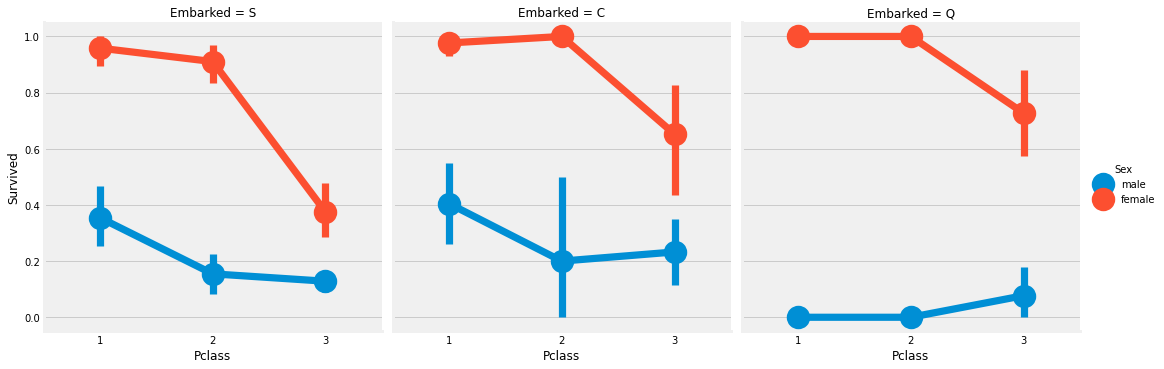

In [64]:
sns.factorplot('Pclass','Survived',hue='Sex',col='Embarked',data=data)
plt.show()

- Pclass 1과 Pclass 2의 여성들은 항구와 상관없이 생존률이 거의 1이다.
- 항구 S는 Pclass 3의 승객들은 여성과 남성 모두 생존률이 가장 낮다.
- 항구 Q는 대부분 Pclass 3이기 때문에 남성들에게 가장 불운해 보인다.

항구 S에서 가장 많은 승객이 있었으므로 Emarked의 NaN값을 S으로 대체한다.

In [66]:
data['Embarked'].fillna('S',inplace=True)

In [67]:
data.Embarked.isnull().any()  # False 반환 : NaN값 없음

False

### 1.1.5. SibSp : Discrete Feature (이산형 변수)

Sibling = 형제자매 <br>
Spouse = 부부

In [68]:
pd.crosstab([data.SibSp],data.Survived).style.background_gradient(cmap='summer_r')

Survived,0,1
SibSp,,
0,398,210
1,97,112
2,15,13
3,12,4
4,15,3
5,5,0
8,7,0


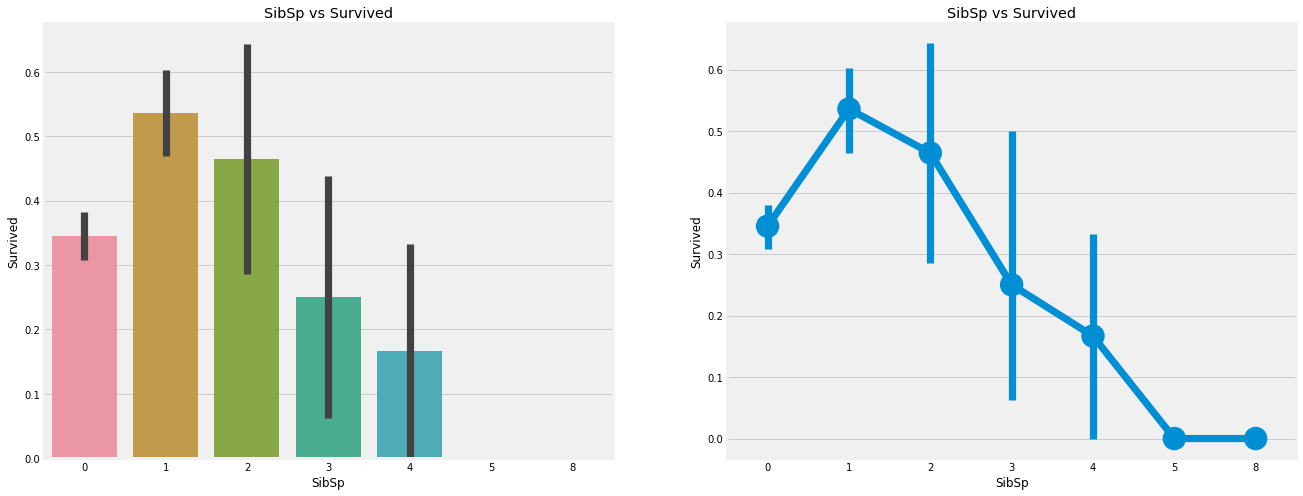

In [71]:
f, ax = plt.subplots(1,2,figsize=(20,8))
sns.barplot('SibSp','Survived',data=data,ax=ax[0])
ax[0].set_title('SibSp vs Survived')

sns.pointplot('SibSp','Survived',data=data,ax=ax[1])
ax[1].set_title('SibSp vs Survived')

plt.close(2)
plt.show()

In [72]:
pd.crosstab(data.SibSp,data.Pclass).style.background_gradient(cmap='summer_r')

Pclass,1,2,3
SibSp,,,
0,137,120,351
1,71,55,83
2,5,8,15
3,3,1,12
4,0,0,18
5,0,0,5
8,0,0,7


위 그래프는 형제자매 없이 혼자인 승객이 34.5%의 생존률을 보여준다. 그래프는 형제자매 수가 증가하면 소폭 상승한다. 놀랍게도 5~8명의 가족의 생존률은 0%인데, 이유는 Pclass이다. crosstab을 통해 SibSp이 3보다 많은 승객은 모두 Pclass 3이라는 것을 알 수 있다. 

### 1.1.6. Parch : Discrete Feature

parch : 부모, 자녀의 수

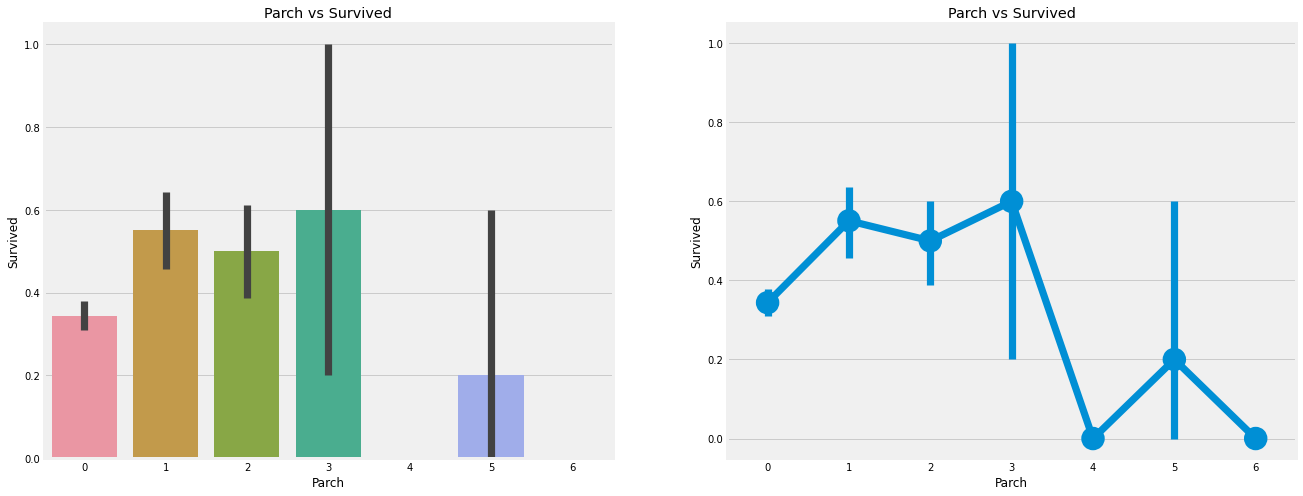

In [74]:
f, ax = plt.subplots(1,2,figsize=(20,8))
sns.barplot('Parch','Survived',data=data,ax=ax[0])
ax[0].set_title('Parch vs Survived')

sns.pointplot('Parch','Survived',data=data,ax=ax[1])
ax[1].set_title('Parch vs Survived')

plt.close(2)
plt.show()

거의 비슷한 결과이다. 부모와 함께한 승객은 생존률이 더 높지만, 수가 증가할수록 생존률은 감소한다. 1~3명의 부모와 함께한 승객의 생존률이 높다. 혼자인 승객과 부모,자녀가 4명모다 많은 승객은 생존률이 낮다.

### 1.1.7. Fare : Continuous Feature

In [76]:
print('가장 높은 요금 :',data['Fare'].max())
print('가장 낮은 요금 :',data['Fare'].min())
print('요금 평균 :', data['Fare'].mean())

가장 높은 요금 : 512.3292
가장 낮은 요금 : 0.0
요금 평균 : 32.204207968574636


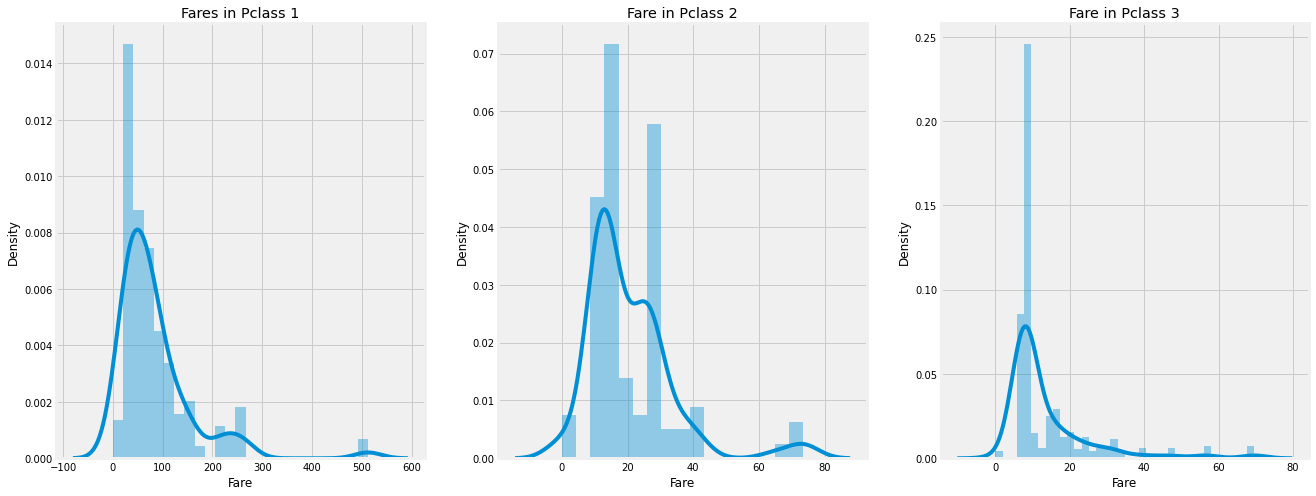

In [77]:
f, ax = plt.subplots(1,3,figsize=(20,8))
sns.distplot(data[data['Pclass']==1].Fare,ax=ax[0])
ax[0].set_title('Fares in Pclass 1')

sns.distplot(data[data['Pclass']==2].Fare,ax=ax[1])
ax[1].set_title('Fare in Pclass 2')

sns.distplot(data[data['Pclass']==3].Fare,ax=ax[2])
ax[2].set_title('Fare in Pclass 3')

plt.show()

feature 정리 <br>
- Sex : 여성이 생존률이 높다.
- Pclass : 1이 생존률이 가장 높고 3이 가장 낮다. 여성의 경우 1에서는 생존률이 거의 1이고 2에서도 높다.
- Age : 5~10세 이하 어린이가 생존률이 높고, 15~35세 승객이 생존률이 낮다.
- Embarked : Pclass 1 승객이 S에서 가장 많았는데도 C가 생존률이 더 높다. Q의 승객은 모두 Pclass 3이다.
- Parch+SibSp : 1~2명의 SibSp이나 1~3명의 부모,자녀가 함께 한 승객은 혼자나 대가족인 승객보다 생존률이 높다.

### Correlation Between the Features

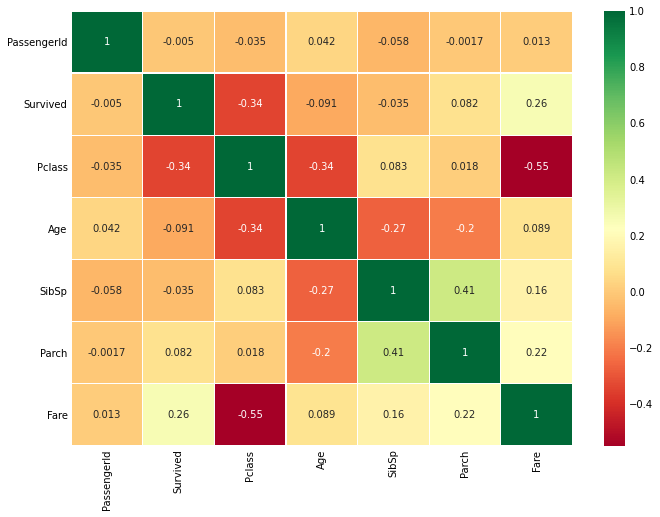

In [78]:
sns.heatmap(data.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)  # data.corR()->correlation matrix
fig = plt.gcf()
fig.set_size_inches(10,8)
plt.show()

- 양의 상관관계 : feature A의 증가가 feature B의 증가로 이어진다면 양의 상관관계이고 1에 가까워진다.
- 음의 상관관계 : feature A의 증가가 feature B의 감소로 이어진다면 음의 상관관계이고 -1에 가까워진다.
- 상관관계가 높을수록 두 feature가 유사한 정보를 포함하고 있으며 정보의 분산이 거의 없다. 이것을 MultiColinearity라고 부른다. 모델을 만들기 위해 이 두 feature 중 하나는 제거한다. 하지만 위의 heatmap에서 상관관계가 높은 것이 없으므로(가장 높은 상관관계가 SibSp와 Parch의 0.41) 제거할 feature는 없다.

# 2. Feature Engineering and Data Cleaning

모든 feature가 중요할 필요는 없다. 불필요한 feature는 제거하고, 다른 feature로부터 새로운 feature를 추가할 수도 있다. 또한 feature를 예측 모델링에 맞게 변환한다.

## 2.1. Age_band

Age는 연속형 변수이므로 머신러닝 모델에 적합하지 않다. 따라서 연속형 변수는 범주형 변수로 바꿔준다. 나이 최댓값이 80이므로 5개의 범주로 나누려면 16 크기의 범주로 나눠야한다.

In [79]:
data['Age_band'] = 0
data.loc[data['Age']<=16,'Age_band'] = 0
data.loc[(data['Age']>16)&(data['Age']<=32),'Age_band'] = 1
data.loc[(data['Age']>32)&(data['Age']<=48),'Age_band'] = 2
data.loc[(data['Age']>48)&(data['Age']<=64),'Age_band'] = 3
data.loc[data['Age']>64,'Age_band'] = 4
data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Age_band
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2


In [80]:
data['Age_band'].value_counts().to_frame().style.background_gradient(cmap='summer') 

,Age_band
1,382
2,325
0,104
3,69
4,11


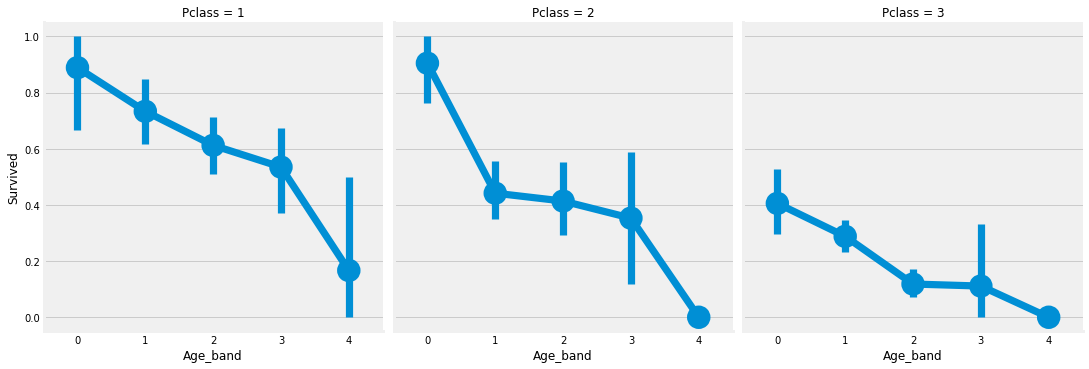

In [81]:
sns.factorplot('Age_band','Survived',data=data,col='Pclass')
plt.show()

Pclass와 상관없이 연령이 증가할수록 생존률이 감소한다.

## 2.2. Family_Size and Alone

'Family_Size'와 'Alone' feature를 만들어 분석해보자. Parch와 SibSp을 합한 것으로, 가족 규모와 관련 있는지를 확인할 수 있다. 'Alone'은 승객이 혼자인지 아닌지를 나타낸다. 

In [82]:
data['Family_Size'] = 0
data['Family_Size'] = data['Parch'] + data['SibSp']
data['Alone'] = 0
data.loc[data.Family_Size==0,'Alone'] = 1

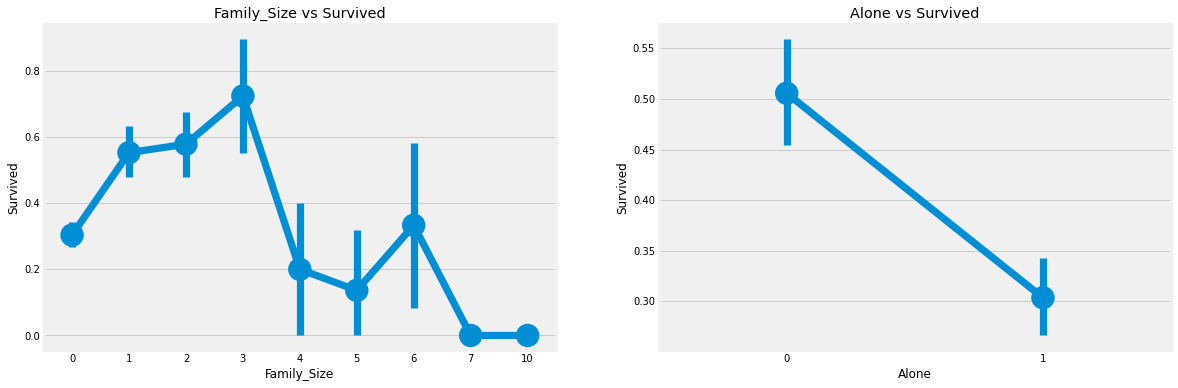

In [85]:
f, ax = plt.subplots(1,2,figsize=(18,6))
sns.pointplot('Family_Size','Survived',data=data,ax=ax[0])
ax[0].set_title('Family_Size vs Survived')

sns.pointplot('Alone','Survived',data=data,ax=ax[1])
ax[1].set_title('Alone vs Survived')

plt.close(2)
plt.close(3)
plt.show()

승객이 혼자거나 가족 크기가 4보다 크면 생존률이 감소한다. 이것은 모델에 중요한 feature로 보인다.

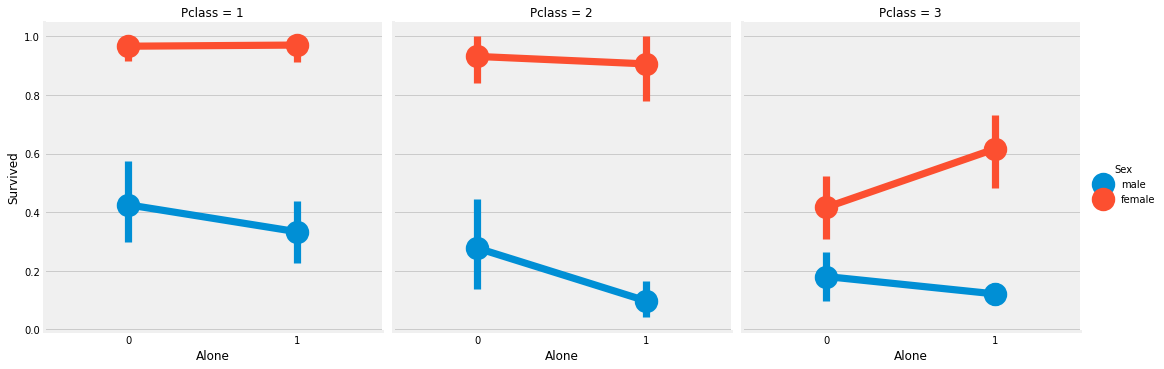

In [87]:
sns.factorplot('Alone','Survived',data=data,hue='Sex',col='Pclass')
plt.show()

Sex나 Pclass에 상관 없이 혼자면 생존률이 낮다. 예외로 여성이 혼자인 확률이 높은 Pclass 3은 가족이 있는 것보다 생존류링 높다.

## 2.3. Fare_Range

Fare 또한 연속형 변수이므로 순서형으로 변환한다. pandas.qcut을 이용한다. qcut은 범주 수에 따라 값의 범위를 동일한 간격으로 나눈다.

In [88]:
data['Fare_Range'] = pd.qcut(data['Fare'],4)
data.groupby(['Fare_Range'])['Survived'].mean().to_frame().style.background_gradient(cmap='summer_r')

,Survived
Fare_Range,
"(-0.001, 7.91]",0.197309
"(7.91, 14.454]",0.303571
"(14.454, 31.0]",0.454955
"(31.0, 512.329]",0.581081


In [89]:
data['Fare_cat'] = 0
data.loc[data['Fare']<=7.91,'Fare_cat'] = 0
data.loc[(data['Fare']>7.91)&(data['Fare']<=14.454),'Fare_cat'] = 1
data.loc[(data['Fare']>14.454)&(data['Fare']<=31),'Fare_cat'] = 2
data.loc[(data['Fare']>31)&(data['Fare']<=513),'Fare_cat'] = 3

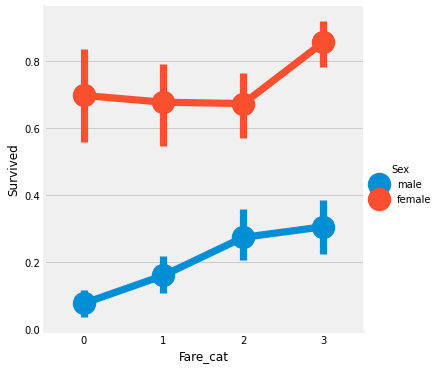

In [90]:
sns.factorplot('Fare_cat','Survived',data=data,hue='Sex')
plt.show()

Fare_cat이 증가할수록 생존률이 증가한다. 중요한 feature가 될지도 모른다.

## 2.4. Converting String Values into Numeric

In [91]:
data['Sex'].replace(['male','female'],[0,1],inplace=True)
data['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
data['Initial'].replace(['Mr','Mrs','Miss','Master','Other'],[0,1,2,3,4],inplace=True)

## 2.5. Dropping Unneeded Features

- Name : 범주화할 수 없으므로 삭제
- Age : Age_band으로 대체
- Ticket : 범주화할 수 없는 랜덤문자열이므로 삭제
- Fare : Fare_cat으로 대체
- Cabin : NaN값이 많으므로 삭제
- Fare_Range : Fare_cat으로 대체
- PassengerId : 범주화할 수 없으므로 삭제

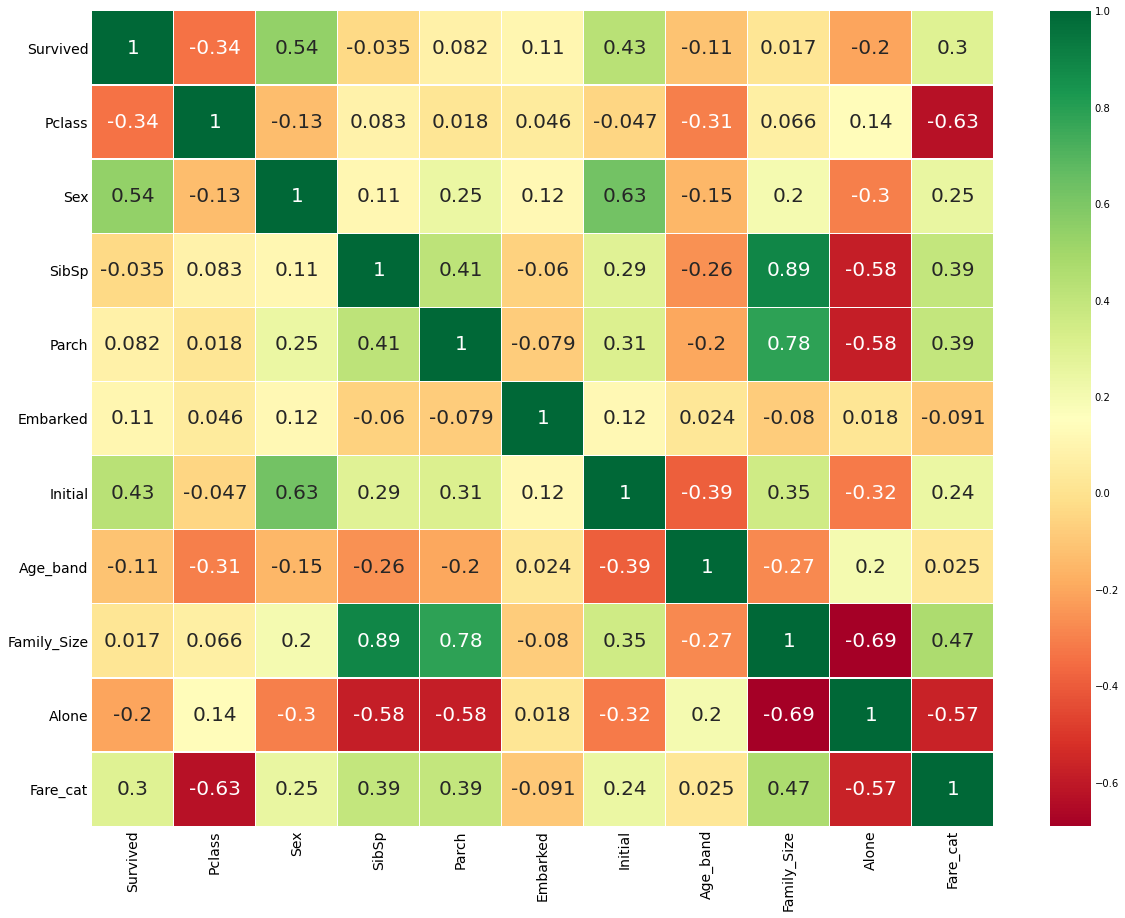

In [93]:
data.drop(['Name','Age','Ticket','Fare','Cabin','Fare_Range','PassengerId'],axis=1,inplace=True)

sns.heatmap(data.corr(),annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':20})
fig = plt.gcf()
fig.set_size_inches(18,15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

위의 heatmap에서 SibSp과 Family_Size, Parch와 Family_Size의 양의 상관관계, Alone과 Family_Size의 음의 상관관계를 볼 수 있다.

# 3. Predictive Modeling

사용할 모델 : Logistic Regression | Support Vector Machines (Linear / radial) | Random Forest | K-Nearest Neighbours | Naive Bayes | Decision Tree | Logistic Regression

In [94]:
# importing all the required ML packages
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree

from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix

In [95]:
train, test = train_test_split(data,test_size=0.3,random_state=0,stratify=data['Survived'])
train_X = train[train.columns[1:]]
train_Y = train[train.columns[:1]]
test_X = test[test.columns[1:]]
test_Y = test[test.columns[:1]]
X = data[data.columns[1:]]
Y = data['Survived']

## 3.1. Running Basic Algorithms

### 3.1.1. Radial Support Vector Machines (rbf-SVM)

In [96]:
model = svm.SVC(kernel='rbf',C=1,gamma=0.1)
model.fit(train_X,train_Y)
prediction1 = model.predict(test_X)
print('Accuracy for rbf-SVM is', metrics.accuracy_score(prediction1,test_Y))

Accuracy for rbf-SVM is 0.835820895522388


### 3.1.2. Linear Support Vector Machine (linear-SVM)

In [97]:
model = svm.SVC(kernel='linear',C=0.1,gamma=0.1)
model.fit(train_X,train_Y)
prediction2 = model.predict(test_X)
print('Accuracy for linear-SVM is', metrics.accuracy_score(prediction2,test_Y))

Accuracy for linear-SVM is 0.8171641791044776


### 3.1.3. Logistic Regression

In [99]:
model = LogisticRegression()
model.fit(train_X,train_Y)
prediction3 = model.predict(test_X)
print('The accuracy of the Logistic Rression is', metrics.accuracy_score(prediction3,test_Y))

The accuracy of the Logistic Rression is 0.8134328358208955


### 3.1.4. Decision Tree

In [101]:
model = DecisionTreeClassifier()
model.fit(train_X,train_Y)
prediction4 = model.predict(test_X)
print('The accuracy of the Decision Tree is', metrics.accuracy_score(prediction4,test_Y))

The accuracy of the Decision Tree is 0.8022388059701493


### 3.1.5. K-Nearest Neighbours (KNN)

In [103]:
model = KNeighborsClassifier()
model.fit(train_X,train_Y)
prediction5 = model.predict(test_X)
print('The accuracy of the KNN is', metrics.accuracy_score(prediction5,test_Y))

The accuracy of the KNN is 0.832089552238806


n_neighbors 를 바꿔 KNN 모델의 정확도를 살펴보자. 기본값은 5다.

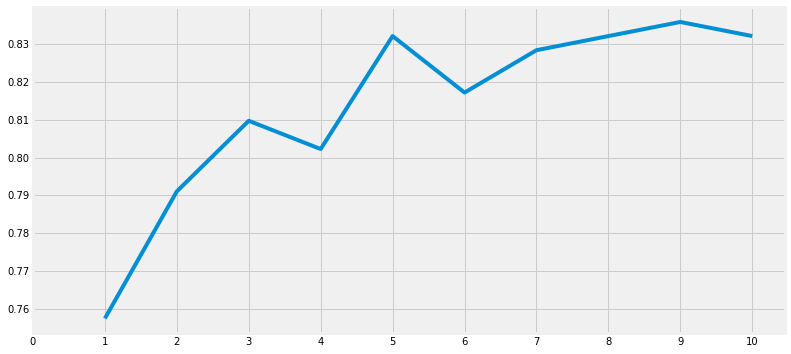

Accuracies for different values of n are: [0.75746269 0.79104478 0.80970149 0.80223881 0.83208955 0.81716418
 0.82835821 0.83208955 0.8358209  0.83208955] with the max value as 0.835820895522388


In [106]:
a_index = list(range(1,11))
a = pd.Series()
x =  [0,1,2,3,4,5,6,7,8,9,10]
for i in list(range(1,11)):
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(train_X,train_Y)
    prediction = model.predict(test_X)
    a = a.append(pd.Series(metrics.accuracy_score(prediction,test_Y)))

plt.plot(a_index, a)
plt.xticks(x)
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.show()

print('Accuracies for different values of n are:', a.values, 'with the max value as', a.values.max())

n = 8일 때 정확도가 0.835820895522388로 가장 높다.

### 3.1.6. Gaussian Naive Bayes

In [107]:
model = GaussianNB()
model.fit(train_X,train_Y)
prediction6 = model.predict(test_X)
print('The accuracy of the NaiveBayes is', metrics.accuracy_score(prediction6, test_Y))

The accuracy of the NaiveBayes is 0.8134328358208955


### 3.1.7. Random Forests

In [109]:
model = RandomForestClassifier(n_estimators=100)
model.fit(train_X,train_Y)
prediction7 = model.predict(test_X)
print('The accuracy of the Random Forest is', metrics.accuracy_score(prediction7,test_Y))

The accuracy of the Random Forest is 0.8097014925373134


모델의 정확도가 분류기의 견고성을 결정하는 유일한 요인은 아니다. training, testing data가 바뀌면 정확도도 바뀐다. 이것을 모델 분산이라고 한다. 따라서 일반화된 모델을 얻기 위해 Cross Validation (교차 검증)을 사용한다.

## 3.2. Cross Validation

### 3.2.1. Cross Validation

데이터가 불균형한 경우가 많다. 예를 들어, class1의 인스턴스가 다른 class보다 많다. 따라서 각 모든 인스턴스에 대해 훈련시키고 테스트해야한다. 그리고 모든 정확도의 평균을 취한다.
1. K-Fold Cross Validation 는 k-subsets으로 dataset을 나눈다.
2. dataset을 k=5개의 부분으로 나누면 테스트를 위해 한 부분을 남기고 4개의 부분으로 알고리즘을 훈련시킨다.
3. 테스트하는 부분을 반복적으로 바꾸며 다른 부분에 대해 알고리즘을 학습시킨다. 그리고 정확도와 오류의 평균을 구해 알고리즘의 정확도 평균을 얻는다.
<br> 이것을 K-Fold Cross Validation이라고 한다.
4. 알고리즘은 적합하지 않거나 지나치게 적합할 수 있는데, 이 때 cross-validation을 통해 일반화된 모델을 얻는다. 

In [113]:
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction

kfold = KFold(n_splits=10, random_state=22, shuffle=True) # k=10 : 10개로 데이터를 분할 
xyz, accuracy, std = [], [], []
classifiers = ['Linear Svm','Radial Svm','Logistic Regression','KNN','Decision Tree','Naive BAyes','Random Forest']
models = [svm.SVC(kernel='linear'),svm.SVC(kernel='rbf'),LogisticRegression(),KNeighborsClassifier(n_neighbors=9),
          DecisionTreeClassifier(),GaussianNB(),RandomForestClassifier(n_estimators=100)]

for i in models:
    model = i
    cv_result = cross_val_score(model,X,Y,cv = kfold, scoring='accuracy')
    cv_result = cv_result
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)
new_models_dataframe2 = pd.DataFrame({'CV Mean':xyz,'Std':std},index=classifiers)
new_models_dataframe2

,CV Mean,Std
Linear Svm,0.784607,0.057841
Radial Svm,0.828377,0.057096
Logistic Regression,0.799176,0.040154
KNN,0.808140,0.040287
Decision Tree,0.805868,0.046996
Naive BAyes,0.795843,0.054861
Random Forest,0.812609,0.040305


<AxesSubplot:>

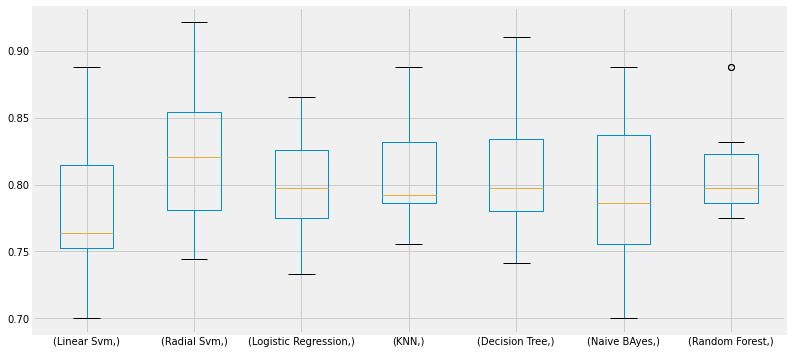

In [114]:
plt.subplots(figsize=(12,6))
box = pd.DataFrame(accuracy,index=[classifiers])
box.T.boxplot()

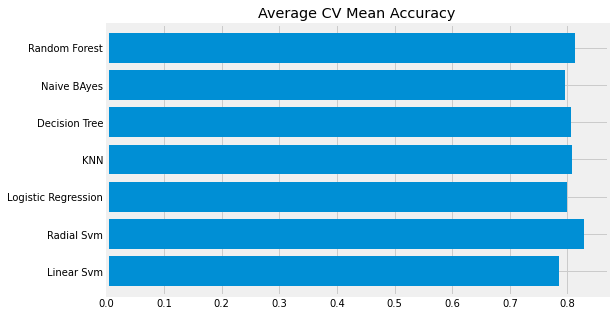

In [115]:
new_models_dataframe2['CV Mean'].plot.barh(width=0.8)
plt.title('Average CV Mean Accuracy')
fig = plt.gcf()
fig.set_size_inches(8,5)
plt.show()

모형이 어디에서 잘못되었는지 또는 모형이 어떤 것을 잘못 예측했는지를 보여주는 confusion matrix로 요약 결과를 얻을 수 있다.

### 3.2.2. Confusion Matrix

Confusion Matrix는 분류기의 옳은 분류와 틀린 분류의 수를 알려준다.

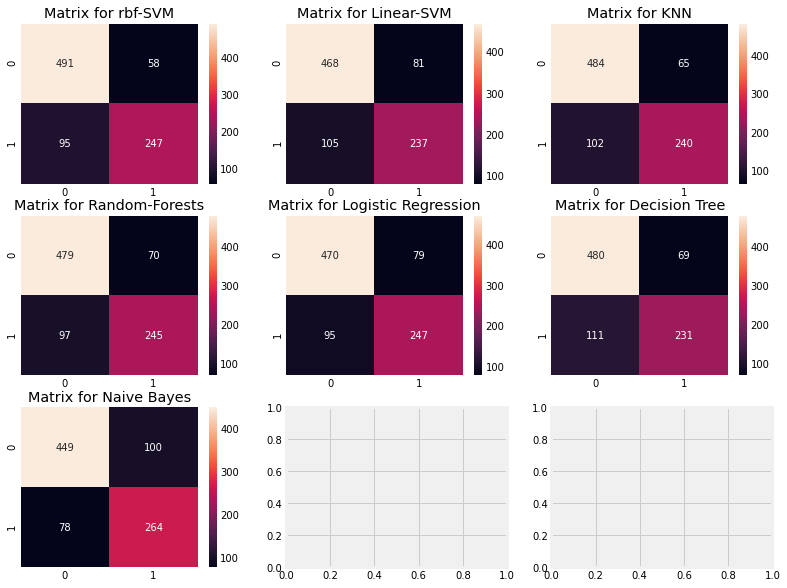

In [117]:
f,ax = plt.subplots(3,3,figsize=(12,10))

y_pred = cross_val_predict(svm.SVC(kernel='rbf'),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,0],annot=True,fmt='2.0f')
ax[0,0].set_title('Matrix for rbf-SVM')

y_pred = cross_val_predict(svm.SVC(kernel='linear'),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,1],annot=True,fmt='2.0f')
ax[0,1].set_title('Matrix for Linear-SVM')

y_pred = cross_val_predict(KNeighborsClassifier(n_neighbors=9),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,2],annot=True,fmt='2.0f')
ax[0,2].set_title('Matrix for KNN')

y_pred = cross_val_predict(RandomForestClassifier(n_estimators=100),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,0],annot=True,fmt='2.0f')
ax[1,0].set_title('Matrix for Random-Forests')

y_pred = cross_val_predict(LogisticRegression(),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,1],annot=True,fmt='2.0f')
ax[1,1].set_title('Matrix for Logistic Regression')

y_pred = cross_val_predict(DecisionTreeClassifier(),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,2],annot=True,fmt='2.0f')
ax[1,2].set_title('Matrix for Decision Tree')

y_pred = cross_val_predict(GaussianNB(),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[2,0],annot=True,fmt='2.0f')
ax[2,0].set_title('Matrix for Naive Bayes')

plt.subplots_adjust(hspace=0.2,wspace=0.2)
plt.show()

좌측위는 올바를 예측 수, 우측 위는 틀린 예측 수이다. rbf-SVM의 confusion matrix를 보자.
- 올바른 예측은 491(사망)+247(생존)이며 평균 CV 정확도는 (491+247)/891 = 82.8%이다.
- 58명의 사망자를 생존자로 잘못 분류했고 95명을 사망자로 분류했다.
- rbf-SVM이 사망자 예측을 잘하고, Naive Bayes가 생존자 예측을 잘한다.

### 3.2.2. Hyper Parameters Tuning

파라미터의 기본값을 조정해 더 나은 모델을 얻을 수 있다. SVM의 C나 gamma 등을 hyper parametes라고 부르며, 학습속도를 바꾸고 더 나은 알고리즘으로 만들 수 있다. SVM과 RandomForest의 hyper parameter를 조정해보자.

#### SVM

In [121]:
from sklearn.model_selection import GridSearchCV
C = [0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1]
gamma = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
kernel = ['rbf','linear']
hyper = {'kernel':kernel,'C':C,'gamma':gamma}

gd = GridSearchCV(estimator=svm.SVC(),param_grid=hyper,verbose=True)
gd.fit(X,Y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
0.8282593685267716
SVC(C=0.4, gamma=0.3)


#### RandomForests

In [122]:
n_estimators = range(100,1000,100)
hyper = {'n_estimators':n_estimators}
gd = GridSearchCV(estimator=RandomForestClassifier(random_state=0),param_grid=hyper,verbose=True)
gd.fit(X,Y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
0.819327098110602
RandomForestClassifier(n_estimators=300, random_state=0)


Rbf-SVM의 최고점수는 C=0.4,gamma=0.3일 때 82.83%이고, RandomForest의 최고점수는 n_estimator=300일 때 81.93%이다.

## 3.3 Ensembling

ensembling은 모형의 정확도나 성능을 높이는 좋은 방법이다. 여러가지 단일모델을 결합해 하나의 강력한 모델을 만들 수 있다. 앙상블은 모델의 안정성을 높인다. 앙상블 방법 : Voting Classifier | Bagging | Boosting

### 3.3.1. Voting Classifier

단순한 머신러닝 모델을 여러개 결합해 예측하는 가장 단순한 방법이다. 모든 하위모델의 예측값의 평균을 낸다. 하위모델은 모두 다른 유형이다.

In [124]:
from sklearn.ensemble import VotingClassifier

ensemble_lin_rbf = VotingClassifier(estimators=[('KNN',KNeighborsClassifier(n_neighbors=10)),
                                               ('RBF',svm.SVC(probability=True,kernel='rbf',C=0.4,gamma=0.3)),
                                               ('RFor',RandomForestClassifier(n_estimators=300,random_state=0)),
                                               ('LR',LogisticRegression(C=0.05)),
                                               ('DT',DecisionTreeClassifier(random_state=0)),
                                               ('NB',GaussianNB()),
                                               ('svm',svm.SVC(kernel='linear',probability=True))],
                                   voting='soft').fit(train_X,train_Y)

print('The accuracy for ensembled model is', ensemble_lin_rbf.score(test_X,test_Y))
cross = cross_val_score(ensemble_lin_rbf,X,Y,cv=10,scoring='accuracy')
print('The cross validated score is',cross.mean())

The accuracy for ensembled model is 0.8208955223880597
The cross validated score is 0.8260424469413234


### 3.3.2. Bagging

bagging은 전형적인 앙상블 기법이다. dataset의 작은 부분에 비슷한 분류기들을 작동시켜 모든 예측값의 평균을 취한다. 평균을 취하기 때문에 분산이 감소한다. Voting Classifier과 달리 배깅은 유사한 하위 분류기를 사용한다.

#### Bagged KNN

배깅은 분산이 높은 모델을 사용할 때 가장 잘 작동한다. (ex.의사결정나무와 랜덤포레스트) 

In [125]:
from sklearn.ensemble import BaggingClassifier
model = BaggingClassifier(base_estimator = KNeighborsClassifier(n_neighbors=3),random_state=0,n_estimators=700)
model.fit(train_X,train_Y)
prediction = model.predict(test_X)
print('The accuracy for bagged KNN is :', metrics.accuracy_score(prediction,test_Y))

result = cross_val_score(model,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for bagged KNN is :', result.mean())

The accuracy for bagged KNN is : 0.835820895522388
The cross validated score for bagged KNN is : 0.8160424469413232


#### Bagged Decision Tree

In [129]:
model = BaggingClassifier(base_estimator = DecisionTreeClassifier(),random_state=0,n_estimators=100)
model.fit(train_X,train_Y)
prediction = model.predict(test_X)
print('The accuracy for bagged Decision Tree is :', metrics.accuracy_score(prediction,test_Y))

result = cross_val_score(model,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for bagged Deicision Tree is :', result.mean())

The accuracy for bagged Decision Tree is : 0.8208955223880597
The cross validated score for bagged Deicision Tree is : 0.8171410736579275


### 3.3.3. Boosting

Boosting은 분류기의 순차 학습을 사용하는 앙상블 기법이다. 약한 모델의 단계적 향상이다. 우선 모델에 완전한 dataset을 학습시키면, 맞은 것도 있고 틀린 것도 있을 것이다. 이제 다음 반복에서, 틀린 예측값에 집중하거나 더 많은 가중치를 둘 것이다. 따라서 틀린 값을 올바르게 예측하려는 것이다. 계속해서 반복하면 정확도의 한계에 다다를 때까지 분류기가 추가된다.

#### AdaBoost (Adaptive Boosting)

이 경우 약한 분류기는 의사결정나무다. 하지만 base_estimator 기본값을 원하는 알고리즘으로 바꿀 수 있다.

In [130]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=200,random_state=0,learning_rate=0.1)
result = cross_val_score(ada,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for AdaBoost is :', result.mean())

The cross validated score for AdaBoost is : 0.8249188514357055


#### Stochastic Gradient Boosting

이 경우도 약한 분류기는 의사결정나무다.

In [140]:
from sklearn.ensemble import GradientBoostingClassifier
grad = GradientBoostingClassifier(n_estimators=500,random_state=0,learning_rate=0.1)
result = cross_val_score(grad,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for Gradient Boosting is :',result.mean())

The cross validated score for Gradient Boosting is : 0.8115230961298376


#### XGBoost

In [146]:
import xgboost as xg
xgboost = xg.XGBClassifier(n_estimators=900,learning_rate=0.1,eval_metric='logloss')  ### 제일 뒤 파라미터는 에러나서 추가한것
result = cross_val_score(xgboost,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for XGBoost is :',result.mean())

The cross validated score for XGBoost is : 0.8160299625468165


AdaBoost의 정확도가 가장 높다. 더 높이기 위해 Hyper Parameter를 조정해보자.

In [147]:
# Hyper-Parameter Tuning for AdaBoost
n_estimators = list(range(100,1000,100))
learn_rate = [0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1]
hyper = {'n_estimators':n_estimators,'learning_rate':learn_rate}
gd = GridSearchCV(estimator=AdaBoostClassifier(),param_grid=hyper,verbose=True)
gd.fit(X,Y)

print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
0.8293892411022534
AdaBoostClassifier(learning_rate=0.1, n_estimators=100)


AdaBoost로 얻을 수 있는 최대 정확도는 n_estimators=100, learning_rate=0.1 일 때 82.94%다.

#### Confusion Matrix for the Best Model

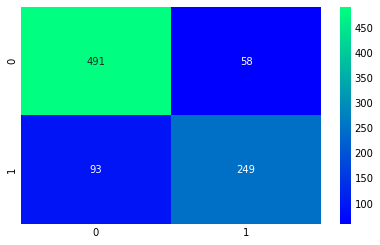

In [148]:
ada = AdaBoostClassifier(n_estimators=100, random_state=0, learning_rate=0.1)
result = cross_val_predict(ada,X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,result),cmap='winter',annot=True,fmt='2.0f')
plt.show()

### 3.3.4. Feature Importance

[23:25:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


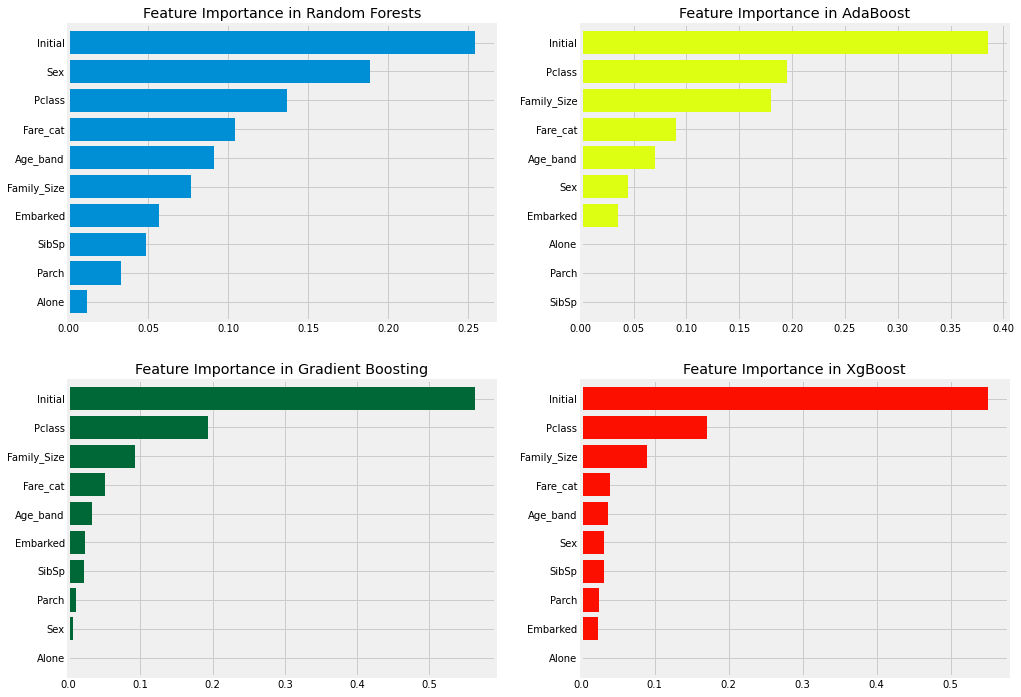

In [149]:
f,ax=plt.subplots(2,2,figsize=(15,12))

model=RandomForestClassifier(n_estimators=500,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[0,0])
ax[0,0].set_title('Feature Importance in Random Forests')

model=AdaBoostClassifier(n_estimators=200,learning_rate=0.05,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[0,1],color='#ddff11')
ax[0,1].set_title('Feature Importance in AdaBoost')

model=GradientBoostingClassifier(n_estimators=500,learning_rate=0.1,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[1,0],cmap='RdYlGn_r')
ax[1,0].set_title('Feature Importance in Gradient Boosting')

model=xg.XGBClassifier(n_estimators=900,learning_rate=0.1)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[1,1],color='#FD0F00')
ax[1,1].set_title('Feature Importance in XgBoost')

plt.show()

RandomForest나 AdaBoost와 같은 다양한 분류기의 중요한 변수를 알 수 있다.

- 주요 변수는 Initial, Fate_cat, Pclass, Family_Size 다.
- Sex 변수는 중요해보이지 않는데, Pclass와 함께한 Sex 변수는 좋은 차별화 요소다. Sex 변수는 RandomForest 에서만 중요해보인다.
- Initial 변수가 모든 분류기에서 중요도가 가장 높고, Sex와 Initial은 둘 다 성별과 관련이 있어 양의 상관관계를 갖는다.
- 비슷하게 Pclass 와 Fare_cat은 승객의 지위와 관련이 있고, Family_Size는 Alone, Parch, SibSp와 관련이 있다.